<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px" />

# # Project 3 : Web API and NLP - Classification Models and Final Summary

## Overview:

1. Since this is multi-classification problem, MultinomialNB and SVC models have been chosen that work best with multi classifier problems.
2. Read csv that has been cleaned with NLP techniques and ready to be modeled
3. Define X and y and get the train, test split from X and y
4. Created first model using Naïve Bayes theorem, Multinomial with GridSearchCV Pipeline using CountVectorizer
5. Create second model using SVM - support vector classifier with GridSearchCV/CountVectorizer and tuned hyper pararmeters.

## Part 1: Imports and Read

In [30]:
#imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.svm import SVC

In [2]:
#read the csv
reddit_df = pd.read_csv("datasets/redditready.csv")
reddit_df.head()

,subreddit,submission_text
0,boardgames,"['hi', 'all', 'really', 'want', 'to', 'get', '..."
1,boardgames,"['my', 'husband', 'and', 'i', 'are', 'looking'..."
2,boardgames,"['do', 'apocalypse', '5e', 'kickstarter']"
3,boardgames,"['i', 've', 'been', 'looking', 'into', 'the', ..."
4,boardgames,"['removed', 'making', 'space', 'for', 'disappo..."


In [3]:
reddit_df.shape

(4500, 2)

## Part 2: Create functions used most commonly

In [4]:
#created functions for repeated tasks
#resources: https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format'''
 
# 1. train_test_split function, returns X and y train and test data
def tt_split ():
    
    X = reddit_df['submission_text']
    y = reddit_df['subreddit']

    X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.25,
                                                     stratify=y, random_state=42)
    
    return X_train, X_test, y_train, y_test

#2. print accuracy scores in notebook
def print_scores(acc_train_score, acc_test_score):
    print(f'Accuracy score on Train Data: {acc_train_score}')
    print(f'Accuracy score on Test Data: {acc_test_score}')
    
#3. print classification report in a dataframe for each model
def get_clf_report(ytest, ypred):
    
    report = classification_report(ytest, ypred, output_dict=True)
    #creating dataframe
    df = pd.DataFrame(report).transpose()
    #sorting by f1-score
    df = df.sort_values(by=['f1-score'], ascending=False)
    return df

In [5]:
#Getting the baseline for y_test
X_train, X_test, y_train, y_test = tt_split()
y_test.value_counts(normalize=True)

Fallout         0.355556
RocketLeague    0.333333
boardgames      0.311111
Name: subreddit, dtype: float64

### Summary:

1. Created common functions above on train_test_split and print our scores
2. Created the base line for y_test 
| Game category  | baseline  |
|---|---|
| Fallout |  0.355556 |
| RocketLeague | 0.333333  |
| boardgames | 0.311111 |


### CountVectorize X Train to view the commonly used words

In [6]:
#create CountVecotrizer to understand the most common text used
X_train, X_test, y_train, y_test = tt_split()
cvec = CountVectorizer(stop_words='english', 
                    ngram_range=(1,2),
                    min_df=2
                   )

cvec.fit(X_train)
X_train = cvec.transform(X_train)
X_test = cvec.transform(X_test)

In [7]:
#validate the most common words
cvec_df = pd.DataFrame(X_train.todense(), columns = cvec.get_feature_names())

cvec_df.sum().sort_values(ascending=False).head(15)

game       2310
fallout    1255
like       1076
just       1043
games      1020
new         743
play        667
ve          556
amp         555
know        540
board       525
time        485
really      414
don         408
help        395
dtype: int64

## Part 2: MultinomialNB Classifier with GridSearchCV/Pipeline/CountVectorizer

In [8]:
#calling ttsplit function to get test and train data
X_train, X_test, y_train, y_test = tt_split()

In [9]:
#Setup pipeline and params for our GridSearchCV
pipe = Pipeline([('cvec', CountVectorizer()),
                ('nb', MultinomialNB())
                ])
        
pipe_params = {'cvec__max_features': [3_000, 4_000],
               'cvec__min_df': [1, 2],
               'cvec__max_df': [.85, .9, .95],
               'cvec__ngram_range': [(1,1), (1,2)]
                }

#initiate GridSearchCV
gs = GridSearchCV(estimator=pipe, param_grid=pipe_params, cv=5)

In [10]:
# Fit the train data
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.85, 0.9, 0.95],
                         'cvec__max_features': [3000, 4000],
                         'cvec__min_df': [1, 2],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [11]:
gs.best_params_

{'cvec__max_df': 0.85,
 'cvec__max_features': 4000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1)}

In [12]:
#print our scores, call function
print_scores (gs.score(X_train, y_train), gs.score(X_test, y_test))

Accuracy score on Train Data: 0.9419259259259259
Accuracy score on Test Data: 0.9217777777777778


In [13]:
#Get predictions
y_pred = gs.predict(X_test)

In [14]:
#Get classification report, call function
get_clf_report(y_test, y_pred)

,precision,recall,f1-score,support
Fallout,0.960317,0.907500,0.933162,400.000000
weighted avg,0.923799,0.921778,0.921951,1125.000000
accuracy,0.921778,0.921778,0.921778,0.921778
macro avg,0.923112,0.921675,0.921568,1125.000000
boardgames,0.929412,0.902857,0.915942,350.000000
RocketLeague,0.879607,0.954667,0.915601,375.000000


In [15]:
# Save confusion matrix values
cm = confusion_matrix(y_test, y_pred)

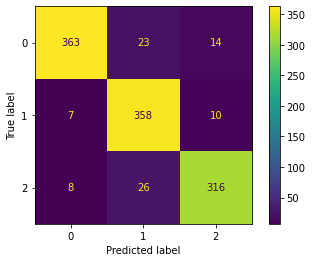

In [16]:
ConfusionMatrixDisplay(cm).plot();

### Summary

**Best hyper parameters for MultinomialNB are:**

1. max_df = 0.85
2. max_features = 4000
3. min_df = 2
4. ngram_range = (1, 1)

## Part 3: Support Vector Machine Model with hyper parameters

In [17]:
# call function to get train_test_split
X_train, X_test, y_train, y_test = tt_split()

In [18]:
cvec = CountVectorizer(stop_words='english', 
                    ngram_range=(1,2),
                    min_df=2
                   )

cvec.fit(X_train)
X_train = cvec.transform(X_train)
X_test = cvec.transform(X_test)

In [19]:
# best hyper parameters
# {'C': 0.4737368421052632, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
pipe_params = {
    'C': np.linspace(0.0001, 1, 20),
    'kernel': ['linear', 'rbf'],
    'degree': [2],
    'gamma' : ['scale']
}
# #instantiate support vector classifier
svc = SVC()
# #instantiate GridSearchCV with njobs=8
gs = GridSearchCV(estimator=svc, param_grid = pipe_params, n_jobs=8, verbose=1)

In [20]:
#fit Train data to our model
gs.fit(X_train,y_train) #commented as we dont need to run

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   25.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:  1.7min finished


GridSearchCV(estimator=SVC(), n_jobs=8,
             param_grid={'C': array([1.00000000e-04, 5.27263158e-02, 1.05352632e-01, 1.57978947e-01,
       2.10605263e-01, 2.63231579e-01, 3.15857895e-01, 3.68484211e-01,
       4.21110526e-01, 4.73736842e-01, 5.26363158e-01, 5.78989474e-01,
       6.31615789e-01, 6.84242105e-01, 7.36868421e-01, 7.89494737e-01,
       8.42121053e-01, 8.94747368e-01, 9.47373684e-01, 1.00000000e+00]),
                         'degree': [2], 'gamma': ['scale'],
                         'kernel': ['linear', 'rbf']},
             verbose=1)

In [21]:
gs.best_params_

{'C': 0.15797894736842105, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}

In [22]:
#print our scores, call function
print_scores (gs.score(X_train, y_train), gs.score(X_test, y_test))

Accuracy score on Train Data: 0.9700740740740741
Accuracy score on Test Data: 0.8542222222222222


In [23]:
#Get predictions
y_pred = gs.predict(X_test)

In [24]:
#Get classification report, call function
get_clf_report(y_test, y_pred)

,precision,recall,f1-score,support
Fallout,0.917333,0.860000,0.887742,400.000000
weighted avg,0.865532,0.854222,0.854891,1125.000000
accuracy,0.854222,0.854222,0.854222,0.854222
macro avg,0.865555,0.852254,0.853797,1125.000000
boardgames,0.918367,0.771429,0.838509,350.000000
RocketLeague,0.760965,0.925333,0.835138,375.000000


In [25]:
# Save confusion matrix values
cm = confusion_matrix(y_test, y_pred)

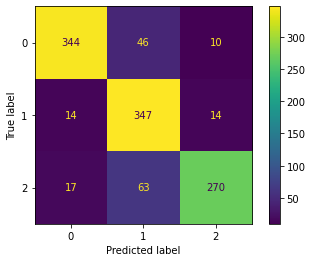

In [26]:
ConfusionMatrixDisplay(cm).plot();

### Summary

** After iterating through hyper parameters, the best parameters identified for SVM model are **
1. C value = 0.4737368421052632
2. kernel = linear
3. degree = 2
4. gamma = scale


### Part Not used: GridSearchCV with MultinomialNB algorithm and TfidfVectorizer

In [28]:
# call function to get train_test_split
X_train, X_test, y_train, y_test = tt_split()

In [31]:
#set the pipeline for tfdif and MiltinomialNB
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])
#include tdiff vector params
pipe_params = {
    'tvec__max_features':[2_000, 3_000, 4_000],
    'tvec__stop_words':['english'],
    'tvec__ngram_range':[(1,2)]
}
# 'tvec__max_features': 3000,
#  'tvec__ngram_range': (1, 1),
#  'tvec__stop_words': None}

In [32]:
#Instantiate GridSearchCV
gs_tvec = GridSearchCV(pipe, param_grid = pipe_params, cv=5)

In [33]:
#Fit with GridSearchCV
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_features': [2000, 3000, 4000],
                         'tvec__ngram_range': [(1, 2)],
                         'tvec__stop_words': ['english']})

In [34]:
gs_tvec.best_params_

{'tvec__max_features': 4000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

In [35]:
#print our scores, call function
print_scores (gs_tvec.score(X_train, y_train), gs_tvec.score(X_test, y_test))

Accuracy score on Train Data: 0.9478518518518518
Accuracy score on Test Data: 0.8995555555555556


In [36]:
#Get predictions
y_pred = gs_tvec.predict(X_test)

In [37]:
#Get classification report, call function
get_clf_report(y_test, y_pred)

,precision,recall,f1-score,support
boardgames,0.922619,0.885714,0.903790,350.000000
Fallout,0.855856,0.950000,0.900474,400.000000
macro avg,0.903936,0.898127,0.899569,1125.000000
accuracy,0.899556,0.899556,0.899556,0.899556
weighted avg,0.902452,0.899556,0.899496,1125.000000
RocketLeague,0.933333,0.858667,0.894444,375.000000


In [38]:
# Save confusion matrix values
cm = confusion_matrix(y_test, y_pred)

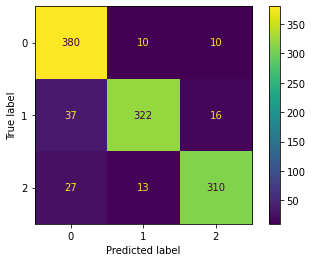

In [39]:
ConfusionMatrixDisplay(cm).plot();